In [1]:
import pandas as pd
import numpy as np
df = pd.read_pickle('tv_data_prep.pkl') 

In [2]:
df.shape

(71403, 41)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71403 entries, 0 to 71402
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         71403 non-null  int64         
 1   number_of_seasons          71403 non-null  int64         
 2   number_of_episodes         71403 non-null  int64         
 3   original_language          71403 non-null  category      
 4   vote_count                 71403 non-null  int64         
 5   vote_average               71403 non-null  float64       
 6   overview                   40925 non-null  string        
 7   adult                      71403 non-null  category      
 8   first_air_date             71403 non-null  datetime64[ns]
 9   last_air_date              71403 non-null  datetime64[ns]
 10  homepage                   71403 non-null  category      
 11  original_name              71402 non-null  string        
 12  popu

In [4]:
from sklearn.preprocessing import LabelEncoder
# transforming number of seasons to categorical by leaving 20 categories 
value_counts = df['number_of_seasons'].value_counts().sort_index().head(20)

# Create bins including an 'above_20' category
bins = list(range(1, 22)) + [float('inf')]  # Range 1-21, and infinity for values above 20
labels = [f'{i}_season' for i in range(1, 21)] + ['above_20_seasons']

# Create the new categorical feature 'number_of_seasons_encoded'
df['number_of_seasons_encoded'] = pd.cut(df['number_of_seasons'], 
                                           bins=bins, 
                                           labels=labels, 
                                           right=False)

df = df.drop('number_of_seasons', axis = 1)


#change category back to int using label encoding

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Fruit' column
df['number_of_seasons_encoded'] = label_encoder.fit_transform(df['number_of_seasons_encoded'])

#rename the number_of_seasons_encoded back to number_of_seasons
df.rename(columns={'number_of_seasons_encoded': 'number_of_seasons'}, inplace=True)

In [5]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

In [6]:
log_df = df.copy()

log_numerical_cols = log_df.select_dtypes(include=['int64', 'float64']).columns
log_numerical_cols = log_numerical_cols.drop('id')

# Define a small constant to add to the values (e.g., 1e-9)
small_constant = 1e-9

# Apply the logarithm to each numerical column, adding the small constant
log_df[log_numerical_cols] = log_df[log_numerical_cols].apply(lambda x: np.log10(x + small_constant))


# Rename the columns by adding the prefix 'log_'
log_df.rename(columns={col: 'log_' + col for col in log_numerical_cols}, inplace=True)

In [7]:
log_df

,id,log_number_of_episodes,original_language,log_vote_count,log_vote_average,overview,adult,first_air_date,last_air_date,homepage,...,genres_War & Politics,genres_Soap,genres_Romance,genres_History,genres_UnKnown,genres_Talk,genres_News,genres_Musical,origin_continent,log_number_of_seasons
0,71446,1.612784e+00,es,4.251297,0.916822,"To carry out the biggest heist in history, a m...",False,2017-05-02,2021-12-03,www.netflix.com,...,False,False,False,False,False,False,False,False,Europe,1.113943
1,66732,1.531479e+00,en,4.208468,0.935709,"When a young boy vanishes, a small town uncove...",False,2016-07-15,2022-07-01,www.netflix.com,...,False,False,False,False,False,False,False,False,North America,1.146128
2,63174,1.968483e+00,en,4.142076,0.928703,"Bored and unhappy as the Lord of Hell, Lucifer...",False,2016-01-25,2021-09-10,www.netflix.com,...,False,False,False,False,False,False,False,False,North America,1.204120
3,69050,2.136721e+00,en,4.119915,0.928345,"Set in the present, the series offers a bold, ...",False,2017-01-26,2023-08-23,Other,...,False,False,False,False,False,False,False,False,North America,1.230449
4,93405,9.542425e-01,ko,4.115710,0.893817,Hundreds of cash-strapped players accept a str...,False,2021-09-17,2021-09-17,www.netflix.com,...,False,False,False,False,False,False,False,False,Asia,1.079181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71398,240293,1.505150e+00,Other,-9.000000,-9.000000,<NA>,False,2023-11-20,2023-12-21,Other,...,False,False,False,False,False,False,False,False,Asia,1.000000
71399,240693,9.030900e-01,de,-9.000000,-9.000000,<NA>,False,2023-11-30,2023-11-30,Other,...,False,False,False,False,False,False,False,False,Europe,1.000000
71400,239099,4.342945e-10,zh,-9.000000,-9.000000,<NA>,False,2023-03-03,2023-03-03,Other,...,False,False,False,False,True,False,False,False,Asia,1.000000
71401,240696,4.342945e-10,Other,-9.000000,-9.000000,"Murder, art and a journalist's relentless ques...",False,2023-11-30,2023-11-30,Other,...,False,False,False,False,False,False,False,False,Asia,1.000000


In [8]:
# Function to identify and treat outliers using IQR
def treat_outliers(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)
    return df_outliers
    
# Apply the outlier treatment function to numeric columns
outliers_df = treat_outliers(df, numeric_df)
outliers_df    

,id,number_of_episodes,vote_count,vote_average,popularity,episode_run_time,number_of_seasons
0,0,1,1,0,1,0,1
1,0,0,1,0,1,0,1
2,0,1,1,0,1,0,1
3,0,1,1,0,1,0,1
4,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...
71398,0,0,0,0,0,0,0
71399,0,0,0,0,0,0,0
71400,0,0,0,0,0,0,0
71401,0,0,0,0,0,0,0


In [9]:
# Checking distribution and correlation changes
from scipy.stats import zscore, ks_2samp
numeric_df = df.select_dtypes(include=['int64', 'float64'])
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

for col in numeric_df:
    out = df[col]
    non_out = df[col][outliers_df[col] == 0]
    cor_out = df['popularity']
    cor_non_out = df['popularity'][outliers_df[col] == 0]
    
    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
    
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'

    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    new_row = pd.DataFrame({'feature': [col],
                            'outliers_cnt': [outliers_df[col].sum()],
                            'distribution_changed': [dist_change],
                            'correlation_changed': [cor_change]})

    out_df = pd.concat([out_df, new_row], ignore_index=True)

/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [10]:
# Add the 'drop' column based on the specified conditions
out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')

# Filter features where only distribution changes but not correlation
to_drop = out_df[out_df['drop'] == 'yes']['feature']

# Display the resulting DataFrame
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,id,0,-,-,no
1,number_of_episodes,7129,+,+,no
2,vote_count,13271,+,+,no
3,vote_average,0,-,-,no
4,popularity,9700,+,-,yes
5,episode_run_time,1055,+,-,yes
6,number_of_seasons,13105,+,-,yes


In [11]:
# Remove outliers
#Clean outliers as long a it is not target value popularity
for col in to_drop:
    if col != 'popularity':  # Check to ensure the column is not 'popularity'
        df.loc[outliers_df[col] == 1, col] = np.nan

In [23]:
# Calculate the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100

# Display the missing percentages
missing_percentage = missing_percentage.reset_index()
missing_percentage.columns = ['Column', 'Missing Percentage']
missing_percentage

,Column,Missing Percentage
0,id,0.000000
1,number_of_episodes,0.000000
2,original_language,0.000000
3,vote_count,0.000000
4,vote_average,0.000000
5,adult,0.000000
6,first_air_date,0.000000
7,popularity,0.000000
8,type,0.000000
9,status,0.000000


In [12]:
from sklearn.impute import KNNImputer
final_df = df.copy()
imp_cols = final_df.select_dtypes(include = ['float64', 'int64']).columns
knn_imputer = KNNImputer(n_neighbors=1)
imputed_data = pd.DataFrame(knn_imputer.fit_transform(final_df[imp_cols]),columns = imp_cols)

In [13]:
final_df[imp_cols] = imputed_data
final_df

,id,number_of_episodes,original_language,vote_count,vote_average,overview,adult,first_air_date,last_air_date,homepage,...,genres_War & Politics,genres_Soap,genres_Romance,genres_History,genres_UnKnown,genres_Talk,genres_News,genres_Musical,origin_continent,number_of_seasons
0,71446.0,41.0,es,17836.0,8.257,"To carry out the biggest heist in history, a m...",False,2017-05-02,2021-12-03,www.netflix.com,...,False,False,False,False,False,False,False,False,Europe,10.0
1,66732.0,34.0,en,16161.0,8.624,"When a young boy vanishes, a small town uncove...",False,2016-07-15,2022-07-01,www.netflix.com,...,False,False,False,False,False,False,False,False,North America,10.0
2,63174.0,93.0,en,13870.0,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,2016-01-25,2021-09-10,www.netflix.com,...,False,False,False,False,False,False,False,False,North America,10.0
3,69050.0,137.0,en,13180.0,8.479,"Set in the present, the series offers a bold, ...",False,2017-01-26,2023-08-23,Other,...,False,False,False,False,False,False,False,False,North America,10.0
4,93405.0,9.0,ko,13053.0,7.831,Hundreds of cash-strapped players accept a str...,False,2021-09-17,2021-09-17,www.netflix.com,...,False,False,False,False,False,False,False,False,Asia,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71398,240293.0,32.0,Other,0.0,0.000,<NA>,False,2023-11-20,2023-12-21,Other,...,False,False,False,False,False,False,False,False,Asia,10.0
71399,240693.0,8.0,de,0.0,0.000,<NA>,False,2023-11-30,2023-11-30,Other,...,False,False,False,False,False,False,False,False,Europe,10.0
71400,239099.0,1.0,zh,0.0,0.000,<NA>,False,2023-03-03,2023-03-03,Other,...,False,False,False,False,True,False,False,False,Asia,10.0
71401,240696.0,1.0,Other,0.0,0.000,"Murder, art and a journalist's relentless ques...",False,2023-11-30,2023-11-30,Other,...,False,False,False,False,False,False,False,False,Asia,10.0


In [14]:
import seaborn as sns

/tmp/ipykernel_3804/901145322.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_df.number_of_episodes)


<Axes: xlabel='number_of_episodes', ylabel='Density'>

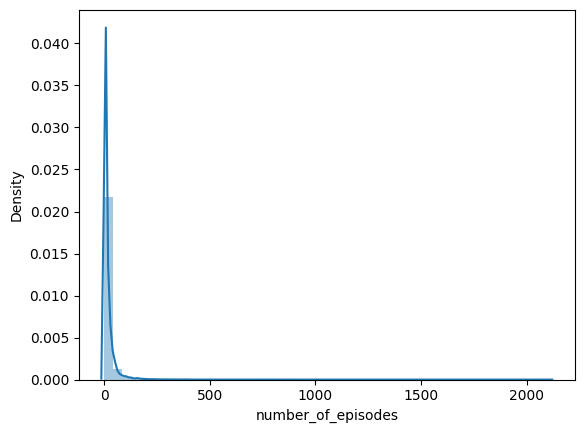

In [15]:
sns.distplot(final_df.number_of_episodes)

/tmp/ipykernel_3804/3924703813.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_df.vote_count)


<Axes: xlabel='vote_count', ylabel='Density'>

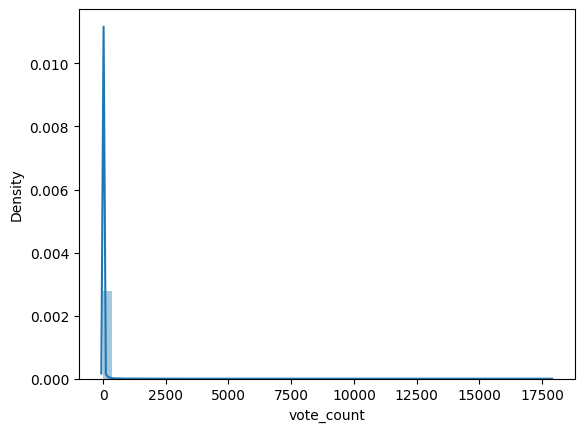

In [16]:
sns.distplot(final_df.vote_count)

/tmp/ipykernel_3804/3966865833.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_df.vote_average)


<Axes: xlabel='vote_average', ylabel='Density'>

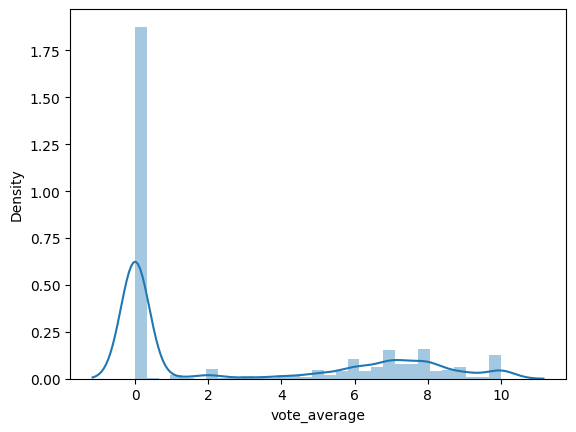

In [17]:
sns.distplot(final_df.vote_average)

/tmp/ipykernel_3804/3674236818.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_df.popularity)


<Axes: xlabel='popularity', ylabel='Density'>

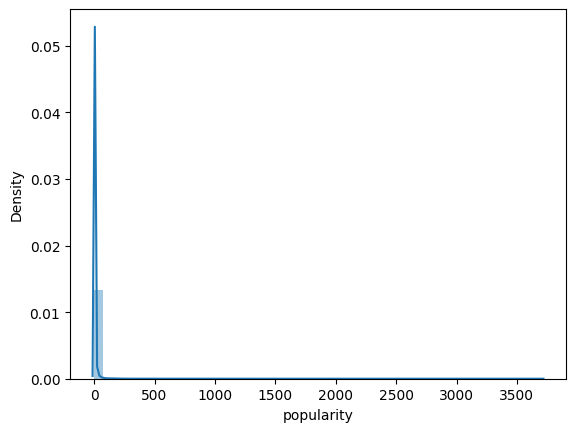

In [18]:
sns.distplot(final_df.popularity)

In [19]:
final_df.to_csv('tv_data_cleansing.csv')
final_df.to_pickle('tv_data_cleansing.pkl')